In [1]:
import json
import textwrap
import time
import os, sys
from copy import deepcopy
from pathlib import Path
from random import sample, shuffle
from typing import List, NoReturn, Optional, Sequence, Set, Tuple

import numpy as np

import torch
from torch.utils.data.dataset import Dataset

import torch_ecg  

from torch_ecg._preprocessors import PreprocManager
from torch_ecg.cfg import CFG
from torch_ecg.databases import CINC2021 as CR
from torch_ecg.utils.ecg_arrhythmia_knowledge import Standard12Leads
from torch_ecg.utils.misc import ReprMixin, list_sum
from torch_ecg.utils.utils_data import ensure_siglen
from torch_ecg.utils.utils_signal import remove_spikes_naive

In [6]:
dataset = CR(db_dir='/home/gridsan/ybo/fairseq-signals/data/physionet/')
dataset

Please wait patiently to let the reader find all records of all the tranches...
records of tranche G are stored in several folders!
Done in 237.51045 seconds!
converting dtypes of columns `diagnosis` and `diagnosis_scored`...


CINC2021(
    db_name = 'challenge-2021',
    db_dir  = PosixPath('/home/gridsan/ybo/fairseq-signals/data/physionet')
)

In [3]:
from data.dataset_wrapper import DatasetWrapper
from data.cinc2021.dataset_cinc2021 import CINC2021

IndentationError: expected an indented block (dataset_wrapper.py, line 20)

In [2]:
from data.cinc2021.dataset_cinc2021 import CINC2021
from data.cinc2021.cfg_cinc2021 import TrainCfg

In [3]:
# train = CINC2021(TrainCfg, training=True)
test = CINC2021(TrainCfg, training=False)

converting dtypes of columns `diagnosis` and `diagnosis_scored`...

start performing train test split...



  0%|          | 0/3453 [00:00<?, ?it/s]

tranche B has 1034 valid records for training

all_classes:     {'TAb', 'AF', 'CLBBB', 'SB', 'AFL', 'IRBBB', 'STach', 'IAVB', 'CRBBB', 'PVC', 'PAC'}
train_classes:   {'TAb', 'AF', 'CLBBB', 'SB', 'AFL', 'IRBBB', 'STach', 'IAVB', 'CRBBB', 'PVC', 'PAC'}
test_classes:    {'TAb', 'AF', 'CLBBB', 'SB', 'AFL', 'IRBBB', 'STach', 'IAVB', 'CRBBB', 'PVC', 'PAC'}
is_valid:        True


                train set saved to 
"/home/gridsan/ybo/fairseq-signals/data/physionet/train_ratio_80_siglen_5000.json"and
"/home/gridsan/ybo/advaug/data/cinc2021/utils/train_ratio_80_siglen_5000.json"
                test set saved to 
"/home/gridsan/ybo/fairseq-signals/data/physionet/test_ratio_20_siglen_5000.json"and
"/home/gridsan/ybo/advaug/data/cinc2021/utils/test_ratio_20_siglen_5000.json"

train test split finished in 2.60 minutes


In [9]:
test._load_all_data()

Loading data:   0%|          | 0/207 [00:00<?, ?records/s]

In [19]:
test._labels.shape

(523, 21)

In [15]:
test_set = ["Q1964", "Q2429", "Q2931", "Q1205", "Q2098", "Q1468", "Q0382", "Q0386", "Q0433", "Q0925", "Q2221", "Q2229", "Q1503", "Q3255", "Q2965", "Q0393", "Q2610", "Q0576", "Q3430", "Q2528", "Q0657", "Q2280", "Q2872", "Q0053", "Q2684", "Q1667", "Q2722", "Q1229", "Q2086", "Q3117", "Q3396", "Q3565", "Q2318", "Q1818", "Q2541", "Q1796", "Q1121", "Q2207", "Q1901", "Q0229", "Q1453", "Q2432", "Q3200", "Q2998", "Q3056", "Q1236", "Q0200", "Q2307", "Q3411", "Q2511", "Q2118", "Q1523", "Q0279", "Q1814", "Q0859", "Q0214", "Q0017", "Q1700", "Q1858", "Q2968", "Q3355", "Q0205", "Q0013", "Q1305", "Q2478", "Q1715", "Q2600", "Q1734", "Q2168", "Q1110", "Q3384", "Q1852", "Q3177", "Q1285", "Q0888", "Q0049", "Q1341", "Q3448", "Q2176", "Q1593", "Q0977", "Q0949", "Q3057", "Q0960", "Q1825", "Q0195", "Q0835", "Q0392", "Q3567", "Q2699", "Q3562", "Q1018", "Q1108", "Q2700", "Q2515", "Q2138", "Q2339", "Q0071", "Q1572", "Q1588", "Q1197", "Q0701", "Q1158", "Q1371", "Q2483", "Q2427", "Q0155", "Q2240", "Q1199", "Q0103", "Q0128", "Q2823", "Q0462", "Q1152", "Q2239", "Q0444", "Q0091", "Q3212", "Q3410", "Q2668", "Q3559", "Q1878", "Q1133", "Q0707", "Q0547", "Q0791", "Q0112", "Q3258", "Q1481", "Q2136", "Q1670", "Q1046", "Q1718", "Q0495", "Q0911", "Q2019", "Q2559", "Q2736", "Q3079", "Q2481", "Q1351", "Q1759", "Q1289", "Q1550", "Q2590", "Q0391", "Q0354", "Q2187", "Q0978", "Q2808", "Q3512", "Q1730", "Q1602", "Q1048", "Q0287", "Q2724", "Q2545", "Q2397", "Q3573", "Q2716", "Q3226", "Q1868", "Q0776", "Q2466", "Q1089", "Q2902", "Q0795", "Q0619", "Q1434", "Q2325", "Q1636", "Q0446", "Q1582", "Q3402", "Q2146", "Q2900", "Q2815", "Q2223", "Q2549", "Q1933", "Q0072", "Q2529", "Q0686", "Q2826", "Q2185", "Q1062", "Q1009", "Q1263", "Q2701", "Q1993", "Q2265", "Q0625", "Q0435", "Q2384", "Q2131", "Q0930", "Q1030", "Q0895", "Q2563", "Q2246", "Q2718", "Q1894", "Q2646", "Q2057", "Q3388", "Q1344", "Q2979"]
len(test_set)

207

In [16]:
train_set = ["Q1196", "Q0145", "Q2948", "Q1484", "Q1618", "Q1871", "Q0273", "Q3395", "Q1210", "Q0800", "Q3356", "Q2013", "Q2909", "Q3566", "Q0890", "Q3157", "Q0921", "Q1426", "Q3517", "Q0100", "Q2919", "Q0250", "Q1802", "Q1567", "Q0556", "Q0718", "Q2076", "Q1949", "Q2493", "Q0318", "Q1336", "Q0738", "Q3392", "Q0502", "Q0967", "Q0302", "Q3501", "Q2499", "Q1323", "Q0538", "Q0972", "Q1267", "Q2088", "Q2557", "Q2244", "Q2727", "Q0116", "Q1520", "Q3481", "Q2143", "Q3229", "Q3142", "Q0515", "Q1074", "Q0045", "Q1372", "Q1542", "Q3231", "Q2028", "Q3081", "Q2041", "Q1001", "Q2588", "Q3283", "Q1975", "Q1774", "Q2917", "Q1899", "Q1907", "Q3141", "Q2166", "Q0702", "Q3118", "Q0037", "Q0240", "Q1448", "Q3540", "Q1911", "Q2012", "Q1771", "Q2904", "Q1379", "Q3496", "Q1405", "Q2835", "Q3310", "Q2779", "Q0916", "Q2602", "Q2099", "Q3269", "Q0184", "Q1207", "Q2167", "Q0863", "Q2618", "Q1204", "Q0494", "Q2887", "Q0022", "Q2740", "Q3145", "Q0390", "Q2844", "Q2543", "Q2926", "Q0463", "Q2433", "Q3546", "Q2647", "Q2943", "Q0604", "Q3465", "Q2074", "Q3062", "Q2560", "Q3316", "Q2116", "Q1942", "Q2951", "Q2348", "Q0646", "Q1905", "Q1672", "Q0178", "Q2672", "Q3431", "Q0268", "Q1055", "Q2533", "Q2034", "Q2145", "Q2435", "Q0206", "Q0349", "Q3126", "Q1324", "Q1171", "Q1332", "Q1406", "Q2482", "Q3021", "Q0394", "Q1687", "Q2953", "Q0648", "Q2253", "Q1279", "Q0848", "Q3076", "Q2135", "Q3107", "Q0046", "Q2786", "Q2778", "Q3347", "Q2377", "Q2717", "Q2046", "Q2276", "Q1325", "Q1255", "Q1452", "Q1156", "Q0300", "Q3271", "Q1717", "Q3301", "Q2271", "Q1424", "Q0936", "Q1622", "Q1776", "Q0973", "Q3279", "Q1544", "Q0298", "Q2937", "Q2671", "Q3561", "Q1850", "Q3074", "Q1203", "Q3066", "Q2170", "Q1888", "Q1732", "Q3381", "Q0516", "Q1377", "Q2346", "Q0506", "Q2636", "Q3343", "Q1546", "Q0976", "Q1417", "Q0078", "Q1545", "Q0825", "Q0320", "Q3443", "Q2069", "Q1974", "Q3008", "Q0092", "Q3006", "Q2693", "Q0790", "Q1499", "Q3352", "Q3521", "Q2878", "Q0593", "Q3158", "Q1553", "Q2367", "Q3535", "Q1650", "Q2899", "Q1370", "Q1117", "Q2791", "Q0730", "Q1652", "Q3449", "Q1514", "Q0307", "Q0434", "Q0522", "Q3240", "Q3266", "Q0025", "Q3342", "Q2322", "Q0571", "Q2698", "Q3168", "Q0276", "Q1070", "Q0183", "Q1856", "Q2413", "Q1808", "Q0136", "Q1321", "Q3558", "Q3122", "Q3450", "Q2572", "Q2122", "Q1851", "Q0508", "Q3026", "Q0225", "Q2077", "Q2811", "Q0260", "Q2214", "Q1172", "Q1217", "Q1407", "Q2151", "Q0749", "Q2261", "Q1742", "Q1791", "Q0204", "Q3108", "Q2485", "Q3137", "Q1722", "Q0998", "Q2750", "Q3432", "Q0767", "Q1322", "Q2883", "Q2306", "Q1945", "Q3315", "Q0962", "Q3209", "Q0096", "Q0437", "Q1302", "Q0671", "Q2666", "Q0027", "Q3289", "Q1634", "Q3294", "Q0691", "Q1238", "Q0374", "Q1560", "Q1524", "Q0579", "Q1892", "Q0653", "Q3205", "Q2164", "Q3354", "Q0211", "Q3270", "Q1873", "Q2633", "Q1132", "Q2834", "Q1026", "Q2362", "Q2839", "Q2710", "Q1278", "Q1675", "Q2434", "Q2079", "Q1903", "Q2884", "Q3222", "Q2524", "Q0264", "Q2473", "Q1186", "Q1810", "Q2195", "Q1352", "Q2257", "Q1689", "Q1486", "Q1087", "Q2283", "Q2613", "Q0650", "Q3193", "Q0901", "Q0778", "Q1179", "Q1510", "Q2120", "Q1614", "Q1248", "Q0629", "Q2924", "Q1482", "Q2235", "Q2357", "Q3040", "Q1234", "Q3138", "Q0095", "Q0026", "Q0596", "Q1552", "Q0395", "Q1232", "Q2254", "Q2323", "Q1144", "Q2266", "Q2653", "Q3065", "Q2709", "Q1928", "Q0407", "Q1190", "Q2651", "Q1836", "Q3216", "Q1464", "Q0309", "Q0312", "Q1747", "Q1740", "Q2585", "Q1798", "Q2472", "Q0704", "Q2674", "Q0127", "Q0158", "Q3570", "Q1433", "Q0387", "Q0709", "Q3105", "Q1611", "Q1581", "Q1023", "Q0642", "Q1983", "Q0647", "Q2512", "Q0984", "Q0343", "Q0995", "Q2901", "Q0412", "Q1201", "Q2880", "Q0597", "Q1288", "Q0036", "Q0630", "Q3250", "Q2523", "Q0196", "Q1704", "Q0226", "Q3444", "Q3406", "Q2226", "Q1939", "Q1525", "Q0602", "Q2308", "Q0350", "Q0769", "Q0010", "Q2208", "Q2789", "Q3490", "Q1096", "Q1671", "Q3441", "Q0138", "Q1665", "Q1805", "Q0040", "Q2665", "Q2321", "Q1777", "Q1307", "Q2867", "Q2270", "Q1843", "Q3221", "Q0306", "Q2905", "Q2597", "Q1599", "Q3030", "Q0050", "Q1785", "Q0994", "Q1780", "Q3087", "Q1015", "Q2137", "Q2803", "Q1451", "Q3371", "Q0885", "Q3383", "Q1937", "Q3470", "Q1438", "Q1517", "Q3101", "Q1272", "Q0968", "Q1313", "Q3403", "Q0115", "Q1908", "Q2132", "Q0424", "Q1111", "Q2682", "Q0608", "Q3555", "Q0039", "Q1857", "Q1177", "Q3106", "Q1349", "Q2534", "Q0526", "Q2475", "Q2788", "Q2797", "Q3024", "Q3288", "Q1879", "Q1731", "Q2790", "Q0372", "Q0364", "Q1495", "Q0029", "Q2431", "Q0566", "Q3550", "Q2906", "Q0929", "Q0836", "Q2222", "Q2215", "Q0209", "Q1082", "Q0198", "Q3051", "Q1467", "Q0041", "Q1659", "Q1694", "Q2500", "Q1019", "Q0692", "Q2175", "Q0860", "Q3262", "Q2806", "Q2289", "Q1714", "Q0510", "Q3486", "Q0248", "Q0077", "Q1702", "Q3073", "Q2479", "Q3198", "Q3556", "Q1275", "Q0512", "Q0380", "Q2516", "Q1505", "Q1487", "Q0487", "Q3075", "Q1485", "Q2949", "Q2802", "Q0990", "Q3422", "Q3088", "Q1909", "Q3378", "Q3265", "Q3161", "Q1146", "Q2611", "Q0944", "Q2637", "Q0181", "Q1817", "Q1754", "Q1673", "Q2586", "Q1266", "Q1752", "Q3281", "Q1308", "Q1970", "Q0590", "Q0513", "Q1565", "Q2888", "Q1860", "Q0384", "Q3391", "Q3234", "Q0291", "Q2001", "Q1792", "Q2179", "Q3188", "Q1227", "Q0946", "Q0849", "Q3295", "Q3346", "Q1533", "Q2093", "Q1343", "Q0121", "Q1037", "Q0500", "Q3290", "Q2177", "Q0223", "Q1299", "Q1286", "Q3370", "Q1032", "Q2015", "Q1682", "Q2628", "Q2390", "Q1280", "Q0151", "Q3203", "Q3183", "Q1797", "Q1083", "Q1300", "Q1017", "Q0550", "Q0986", "Q2539", "Q0760", "Q0897", "Q2233", "Q1373", "Q2574", "Q2942", "Q1946", "Q2344", "Q2624", "Q1113", "Q0886", "Q1335", "Q2680", "Q1243", "Q3233", "Q1660", "Q2831", "Q1615", "Q2952", "Q2062", "Q2962", "Q0048", "Q1530", "Q1710", "Q0033", "Q0808", "Q0388", "Q2703", "Q1233", "Q3553", "Q2487", "Q0001", "Q0979", "Q3358", "Q0759", "Q0673", "Q1991", "Q0370", "Q1554", "Q3575", "Q1989", "Q1564", "Q0531", "Q2531", "Q1208", "Q3098", "Q3337", "Q2492", "Q0333", "Q1367", "Q1029", "Q0662", "Q0220", "Q0948", "Q0074", "Q1870", "Q2110", "Q2868", "Q0717", "Q0549", "Q0588", "Q2454", "Q0951", "Q2558", "Q1812", "Q3169", "Q1042", "Q2793", "Q1968", "Q0772", "Q0551", "Q1363", "Q1532", "Q0038", "Q0585", "Q2180", "Q2045", "Q0665", "Q2767", "Q3125", "Q2915", "Q3195", "Q1020", "Q0572", "Q2284", "Q2621", "Q0643", "Q3104", "Q1320", "Q2196", "Q3568", "Q3000", "Q1617", "Q3332", "Q2761", "Q2522", "Q0094", "Q2392", "Q2893", "Q2410", "Q2713", "Q1147", "Q0461", "Q3023", "Q1435", "Q1831", "Q1375", "Q1578", "Q1676", "Q2025", "Q1941", "Q0423", "Q0870", "Q0342", "Q1115", "Q2471", "Q2055", "Q1619", "Q1756", "Q1408", "Q0357", "Q3033", "Q1765", "Q2190", "Q3418", "Q0188", "Q0851", "Q1389", "Q0234", "Q3563", "Q0830", "Q2282", "Q2227", "Q1462", "Q1966", "Q3503", "Q1198", "Q1549", "Q2100", "Q3190", "Q0218", "Q0887", "Q1342", "Q3210", "Q0666", "Q0134", "Q0575", "Q0449", "Q1762", "Q3204", "Q0877", "Q1527", "Q1016", "Q2977", "Q2097", "Q1191", "Q1492", "Q0750", "Q2852", "Q0416", "Q3405", "Q2292", "Q0239", "Q3327", "Q0592", "Q2520", "Q2378", "Q1875", "Q0454", "Q2824", "Q1955", "Q1972", "Q2650", "Q3276", "Q2596", "Q0660", "Q3096", "Q1141", "Q1397", "Q1449", "Q2277", "Q2008", "Q2165", "Q2913", "Q0910", "Q1404", "Q0411", "Q1982", "Q1489", "Q1707", "Q2319", "Q2631", "Q3009", "Q1994", "Q1965", "Q1920", "Q2669", "Q1167", "Q2912", "Q0568", "Q2056", "Q3344", "Q0530", "Q2061", "Q3004", "Q0480", "Q2748", "Q1477", "Q3207", "Q2161", "Q1693", "Q3321", "Q0324", "Q3536", "Q1270", "Q0523", "Q0122", "Q1794", "Q1345", "Q2128", "Q2121", "Q3202", "Q2337", "Q0257", "Q1139"]
len(train_set)

827

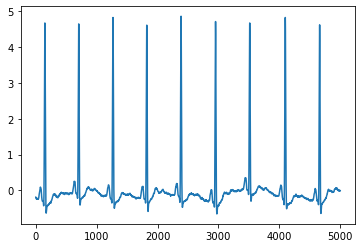

In [14]:
from matplotlib import pyplot as plt

plt.plot(test._signals[0][0])

In [8]:
from torch_ecg.databases import CINC2021 as CR
CR("/home/gridsan/ybo/fairseq-signals/data/physionet")

converting dtypes of columns `diagnosis` and `diagnosis_scored`...


CINC2021(
    db_name = 'challenge-2021',
    db_dir  = PosixPath('/home/gridsan/ybo/fairseq-signals/data/physionet')
)